In [139]:
import pickle as pkl

In [140]:
filename = "sim_results/market-marl-nash-3-04-29-2022-16-26-594_results.pkl"

with open(filename, 'rb') as f:
    res = pkl.load(f)


In [141]:
l = list(dir(res))

In [142]:
import numpy as np
import seaborn as sns

In [143]:
import pandas as pd

sns.set_theme(style="darkgrid")
data_losses = {"Q Function Loss": res.losses, "Epsilon Function Loss": res.losses_eps, "Nash Net Loss": res.losses_nash}
data_losses_df = pd.DataFrame(data=data_losses)
# sns.lineplot(data=data_losses_df)

In [144]:
res.marl_params

{'epochs': 4,
 'explore_epsilon': 0.05,
 'max_steps': 3,
 'sync_freq': 3,
 'mem_size': 101333,
 'turbo_max_evals': 13,
 'turbo_batch_size': 13,
 'turbo_n_init': 13,
 'batch_size': 2}

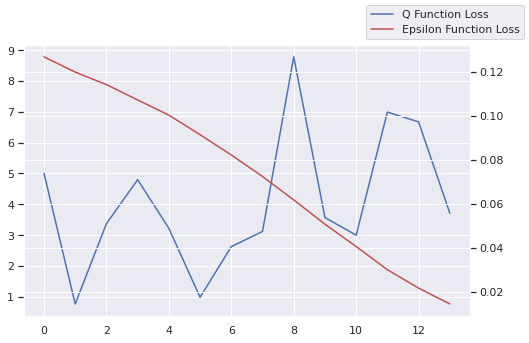

In [145]:
# import matplotlib.pyplot as plt

ax = data_losses_df.plot(y="Q Function Loss", legend=False, figsize=(8, 5))
ax2 = ax.twinx()

# data_losses_df.plot(y="Nash Net Loss", ax=ax2, legend=False, color="r")
# ax.figure.legend()

data_losses_df.plot(y="Epsilon Function Loss", ax=ax2, legend=False, color="r")
ax.figure.legend()


In [146]:
# import matplotlib.pyplot as plt
# sns.lineplot(data=res.losses, color="b", legend="auto")
# ax2 = plt.twinx()
# sns.lineplot(data=res.losses_eps, color="g", ax=ax2)

<AxesSubplot:>

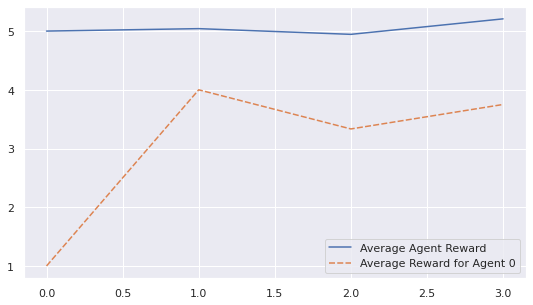

In [147]:
# Plot rewards

data_rewards = {"Average Agent Reward": res.avg_epoch_rewards, "Average Reward for Agent 0": res.avg_epoch_rewards_agent}
data_rewards_df = pd.DataFrame(data=data_rewards)

sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=data_rewards_df)

In [148]:
from environment.TheoreticalMarket import *
import numpy as np

# Theoretical Data
tm = TheoreticalMarket(beta0 = 30, beta1 = -1.1, beta2 = -2, a = 0.1, ref_p = 1.5)
beta0 = 25
beta1 = -0.9
beta2 = -1.1
a = 0.1

# Simulation Data
ep = 2
ref_prices = res.state_tracker[ep]
episode_rewards = res.episode_rewards[ep]
joint_actions = res.episode_actions

prices = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[0] for r in ref_prices])
devs = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[1] for r in ref_prices])
demand = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[2] for r in ref_prices])

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

y = ref_prices
x = prices[0]
X, Y = np.meshgrid(x, y) 
z = devs

# min_eps_price, max_eps_price = get_eps0_range(9.9, Y, X, z)

nash_eps_bounds = [get_eps0_range(ref_price, Y, X, z) for ref_price in ref_prices ]
nash_lower_bound =  [v[0] for v in nash_eps_bounds]
nash_upper_bound =  [v[1] for v in nash_eps_bounds]

# Episode rewards 


In [150]:
avg_ag_rewards = episode_rewards.mean(axis = 1)

<AxesSubplot:>

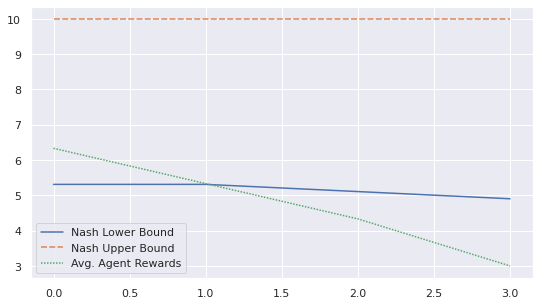

In [151]:
# "Ref Prices": ref_prices, 
nash_bound_per_run = {"Nash Lower Bound": nash_lower_bound, "Nash Upper Bound": nash_upper_bound, "Avg. Agent Rewards": avg_ag_rewards}
nash_bound_per_run_df = pd.DataFrame(data=nash_bound_per_run)

sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=nash_bound_per_run_df)

In [152]:
nash_bound_per_run_df

,Nash Lower Bound,Nash Upper Bound,Avg. Agent Rewards
0,5.310816,10.0,6.333333
1,5.310816,10.0,5.333333
2,5.106939,10.0,4.333333
3,4.903061,10.0,3.000000


In [153]:
res.episode_rewards[0]

array([[ 2.,  6.,  3.],
       [ 9.,  4.,  3.],
       [ 1.,  3., 10.],
       [ 1.,  9.,  9.]])

In [154]:
state_key = [0.0, 0.0, 0.0, 3.0]

res.sna_policy_dict_iter[repr(state_key)][0]

In [155]:
max_p = 0
agent_id = 0
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)

0.01613973494572862
0.10296090198875209
0.16083029602860288
0.1461489304897643
0.15757603774752652
0.09235803217794523
0.030641173075257325
0.11371351492235424
0.11925818772284409
0.06037319090122475
2


In [156]:
max_p = 0
agent_id = 1
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.026686099745330094
0.05015684457868438
0.07355400494372813
0.05099681048723901
0.08070044850213352
0.10733440799450165
0.24279660431174135
0.037534582784102974
0.14983139981843394
0.18040879683410496
6


In [157]:
max_p = 0
agent_id = 2
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.1396894499991372
0.052562993495149195
0.16412118277263185
0.12004826778542435
0.10178134406488427
0.08592188832763123
0.05274248208952549
0.08001552946765883
0.08607195533157862
0.11704490666637904
2


In [158]:
res.state_tracker

array([[1.62592518, 3.66666667, 5.33333333, 4.66666667],
       [6.33333333, 4.        , 6.33333333, 3.66666667],
       [6.33333333, 6.33333333, 5.33333333, 4.33333333],
       [3.        , 7.        , 4.33333333, 8.33333333]])